In [1]:
%matplotlib inline

In [2]:
import pickle
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from helpers import LFR_Data, load_or_calc_and_save, ytrue_to_partition, perform_graph

# Prepare results of SBM – Stochastic Block Model

In [3]:
data_hub = LFR_Data()

In [10]:
@load_or_calc_and_save(f'{data_hub.CACHE_ROOT}/lfr_inits_bestparam_byari_individual.pkl', force_calc=True)
def sbm_inits_bestparam_byari_individual():
    results = {}
    for dataset in tqdm(data_hub.datasets):  # dataset = column in this context
        @load_or_calc_and_save(f'{data_hub.CACHE_ROOT}/lfr_inits_bestparam_byari_individual/{dataset}.pkl')
        def calculate_dataset():
            dataset_results = {}
            for kernel_name in tqdm(data_hub.kernel_names, desc=dataset):
                filename = f'{dataset}_{kernel_name}_results.pkl'
                try:
                    with open(f'{data_hub.LFR_RESULTS_ROOT}/by_column/{dataset}/{filename}', 'rb') as f:
                        data = pickle.load(f)
                except EOFError:
                    print(filename)
                    raise
                for graph_idx in range(5):
                    _, best_ari, _ = perform_graph(data[graph_idx]['results'])  # {scorename_initname: (best_param, init)}
                    result = {si: init['score_ari'] for si, (_, init) in best_ari.items()}  # {scorename_initname: best_ari}
                    print(result)
                    raise Exception()
                    dataset_results[(kernel_name, graph_idx)] = result
            return dataset_results
        
        dataset_results = calculate_dataset()
        for (kernel_name, graph_idx), result in dataset_results.items():
            results[(dataset, kernel_name, graph_idx)] = result
    return results

results = sbm_inits_bestparam_byari_individual() # {(dataset, kernel_name, graph_idx): {scorename_initname: best_ari}}

sbm_inits_bestparam_byari_individual: RECALC ../../cache/cache/lfr_inits_bestparam_byari_individual.pkl. args: , kwargs: 


calculate_dataset: RECALC ../../cache/cache/lfr_inits_bestparam_byari_individual/dataset2lfr_dolphins.pkl. args: , kwargs: 


{'inertia_one': 1.0, 'inertia_all': 1.0, 'inertia_kmp': 1.0, 'inertia_any2': 1.0, 'inertia_any3': 1.0, 'modularity_one': 0.5433470176285922, 'modularity_all': 1.0, 'modularity_kmp': 0.7536532664896747, 'modularity_any2': 0.8122028032648086, 'modularity_any3': 0.6971136904825465}


Exception: 

In [5]:
# table for modularity any3
results_m3_dka = defaultdict(lambda: defaultdict(list)) # {dataset, {kernel_name: [best_ari_for_graph]}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_m3_dka[dataset][kernel_name].append(si_ari['modularity_any3'] if 'modularity_any3' in si_ari else 0)
for dataset, kernel_name in product(data_hub.datasets, data_hub.kernel_names):  # {dataset, {kernel_name: mean_bestari}}
    results_m3_dka[dataset][kernel_name] = np.mean(results_m3_dka[dataset][kernel_name])

df = pd.DataFrame(results_m3_dka)
df.to_excel('./results/lfr_modularity_any3_bestparam_byari_individual.xlsx')

dataset_meanari = {k: np.mean(list(v.values())) for k, v in results_m3_dka.items()}  # {dataset, mean_mean_bestari}
for dataset, meanari in sorted(list(dataset_meanari.items()), key=lambda x: x[1]):
    print(f'{dataset}: {meanari:.2f}')

dataset2lfr_cora_HCI: 0.00
dataset2lfr_cora_EC: 0.00
dataset2lfr_cora_Net: 0.05
dataset2lfr_cora_DB: 0.11
dataset2lfr_news_5cl3_0.1: 0.14
dataset2lfr_cora_IR: 0.24
dataset2lfr_dolphins: 0.43
dataset2lfr_karate: 0.69
dataset2lfr_news_5cl1_0.1: 0.70
dataset2lfr_news_5cl2_0.1: 0.70
dataset2lfr_news_2cl2_0.1: 0.72
dataset2lfr_news_3cl2_0.1: 0.76
dataset2lfr_news_3cl3_0.1: 0.81
dataset2lfr_news_3cl1_0.1: 0.82
dataset2lfr_news_2cl1_0.1: 0.84
dataset2lfr_polblogs: 0.88
dataset2lfr_news_2cl3_0.1: 0.90


In [6]:
@load_or_calc_and_save(f'{data_hub.CACHE_ROOT}/lfr_modularity.pkl', force_calc=True)
def sbm_modularity():
    modularity_results = {}
    for dataset in tqdm(data_hub.datasets):  # dataset = column in this context
        filename = f'{dataset}_graphs.pkl'
        with open(f'{data_hub.LFR_RESULTS_ROOT}/graphs/{filename}', 'rb') as f:
            data = pickle.load(f)
        for graph_idx in range(5):
            try:
                (A, y_true), _ = data[graph_idx]
            except:
                (A, y_true) = data[graph_idx]
            partition = ytrue_to_partition(y_true)
            modularity = nx.community.modularity(nx.from_numpy_matrix(A), partition)
            modularity_results[(dataset, graph_idx)] = modularity
    return modularity_results

modularity_results = sbm_modularity()  # {(dataset, graph_idx): modularity}

sbm_modularity: RECALC ../../cache/cache/lfr_modularity.pkl. args: , kwargs: 


In [7]:
dataset_modularity = dict()
for dataset in data_hub.datasets:
    dataset_modularity[dataset] = np.mean([modularity_results[(dataset, graph_idx)] for graph_idx in range(5)])
for dataset, modularity in sorted(list(dataset_modularity.items()), key=lambda x: x[1]):
    print(f'{dataset}: {modularity:.2f}')

dataset2lfr_news_5cl3_0.1: 0.23
dataset2lfr_news_2cl2_0.1: 0.27
dataset2lfr_karate: 0.31
dataset2lfr_news_2cl1_0.1: 0.34
dataset2lfr_polblogs: 0.35
dataset2lfr_news_5cl2_0.1: 0.36
dataset2lfr_cora_DB: 0.36
dataset2lfr_news_3cl2_0.1: 0.36
dataset2lfr_news_2cl3_0.1: 0.40
dataset2lfr_cora_Net: 0.42
dataset2lfr_news_3cl3_0.1: 0.43
dataset2lfr_news_5cl1_0.1: 0.43
dataset2lfr_cora_IR: 0.44
dataset2lfr_news_3cl1_0.1: 0.50
dataset2lfr_dolphins: 0.55
dataset2lfr_cora_HCI: 0.79
dataset2lfr_cora_EC: 0.92


Text(0, 0.5, 'ARI')

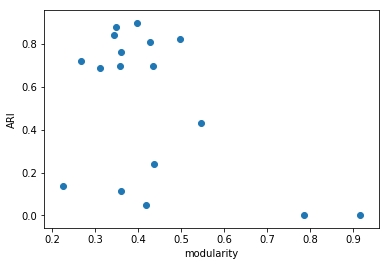

In [8]:
# draw ari-modularity dependency
x, y = [], []
for dataset in data_hub.datasets:
    x.append(dataset_modularity[dataset])
    y.append(dataset_meanari[dataset])
plt.scatter(x, y)
plt.xlabel('modularity')
plt.ylabel('ARI')